# COVID-19 Kaggle Challenge
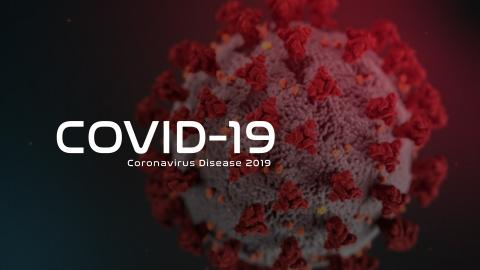

**Task: What do we know about vaccines and therapeutics?** 

The goal of this task is to use the given medical data set and find answers to questions related to the ongoing COVID-19 pandemic.


# Overview of approach


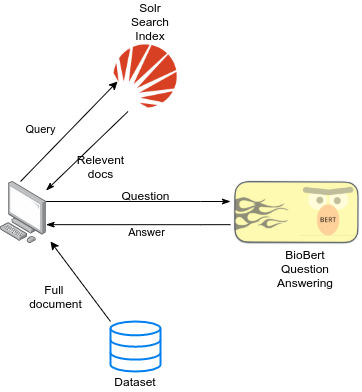

The approach can be divided into two main steps:
1. Document Retrieval
2. Question Answering

In [ ]:
!pip install pysolr
!pip install transformers
!pip install pandas

In [ ]:
from pysolr import Solr
import json
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, BertForQuestionAnswering
import shutil
import torch
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import requests
from bs4 import BeautifulSoup

In [ ]:
stop_words = set(stopwords.words('english'))
title_dict = {}

# **Document Search/Retrieval System**

We use an [Apache Solr](https://lucene.apache.org/solr/) server hosted on an AWS EC2 instance to retrieve list of relevant documents using the pysolr library.

The server returns the folder and file name for the relevant documents. The index doesn't store a copy of the text in the document. 

Index was uses synonym check, Stop word removal and Stemming.

Documents are ranked using BM25


In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("solr_server")
solr = Solr(secret_value_0)

In [ ]:
def preprocess(outer_folder, folder_name):
    fname = "../input/CORD-19-research-challenge/"+outer_folder+folder_name + "/"
    contents = os.listdir(fname)
    address = "processed/" + folder_name + "/"
    new_files = []
    result = solr.search("path:"+ folder_name + " path: " + folder_name + "/", rows=40000, **{"fl":"id"})
    dct = set()
    for i in result:
        dct.add(address + i["id"])
    new_docs = set()
    for i in contents:
        d = json.load(open(fname+i))
        id = d['paper_id']
        path = folder_name
        title=d['metadata']['title']
        abstract = ""
        if 'abstract' in d:
            abst = d['abstract']
            for j in abst:
                abstract = abstract + j["text"] + "\n"
        body = ""
        for j in d['body_text']:
            body = body + j["text"] + "\n"
        data = {}
        title_dict[id]=title
        data['title']=title
        data['abstract']=abstract
        data['id']=id
        data['body']=body
        data['path']=path
        with open(address+i,'w') as out:
            json.dump(data,out)
        new_docs.add(address + id)
        #new_files.append(address+i)
    to_add = new_docs.difference(dct)
    to_remove = dct.difference(new_docs)
    return [*to_add,], [*to_remove,]

In [ ]:
# Create directory structure for processed files
def modify_directory_structure():
    if not os.path.exists("processed"):
        os.mkdir("processed")

    if not os.path.exists("processed/biorxiv_medrxiv"):
        os.mkdir("processed/biorxiv_medrxiv")
    if not os.path.exists("processed/biorxiv_medrxiv/pdf_json"):
        os.mkdir("processed/biorxiv_medrxiv/pdf_json")

    if not os.path.exists("processed/comm_use_subset"):
        os.mkdir("processed/comm_use_subset")
    if not os.path.exists("processed/comm_use_subset/pdf_json"):
        os.mkdir("processed/comm_use_subset/pdf_json")
    if not os.path.exists("processed/comm_use_subset/pmc_json"):
        os.mkdir("processed/comm_use_subset/pmc_json")

    if not os.path.exists("processed/noncomm_use_subset"):
        os.mkdir("processed/noncomm_use_subset")
    if not os.path.exists("processed/noncomm_use_subset/pdf_json"):
        os.mkdir("processed/noncomm_use_subset/pdf_json")
    if not os.path.exists("processed/noncomm_use_subset/pmc_json"):
        os.mkdir("processed/noncomm_use_subset/pmc_json")

    if not os.path.exists("processed/custom_license"):
        os.mkdir("processed/custom_license")
    if not os.path.exists("processed/custom_license/pdf_json"):
        os.mkdir("processed/custom_license/pdf_json")
    if not os.path.exists("processed/custom_license/pmc_json"):
        os.mkdir("processed/custom_license/pmc_json")


Solr Index can be built incrementally so the index can be modified to include new documents and delete the removed documents. 

In [ ]:
#Updating index in batches of 500 to prevent http request timeout
def update_index(new_files):
    j = 0
    while j < len(new_files): 
        x = []
        for i in new_files[j:j+500]:
            if 'PMC' in i:
                r = json.load(open(i+'.xml.json','r'))
            else:
                r = json.load(open(i+'.json','r'))
            x.append(r)
        j = j + 500
        solr.add(x)
        
# Remove those documents from the index which have been removed from dataset
def clean_index(removable_files):
    j = 0
    while j < len(removable_files): 
        x = ""
        for i in removable_files[j:j+10]:
            x = x + "id: " + i.split('/')[-1] + " "
        j = j + 10 #Update is done in batches of size 10 due to URL size restriction
        solr.delete(q=x)
           
def handle_changes():
    modify_directory_structure()
    new_files = []
    removable_files = []
    n1, r1 = preprocess('biorxiv_medrxiv/','biorxiv_medrxiv/pdf_json')
    new_files = new_files + n1
    removable_files = removable_files + r1
    print(len(new_files))
    print(new_files[:10])
    
    n1, r1 = preprocess('comm_use_subset/','comm_use_subset/pdf_json')
    new_files = new_files + n1
    removable_files = removable_files + r1
    
    n1, r1 = preprocess('comm_use_subset/','comm_use_subset/pmc_json')
    new_files = new_files + n1
    removable_files = removable_files + r1
    print(len(new_files))
    
    
    n1, r1 = preprocess('noncomm_use_subset/','noncomm_use_subset/pdf_json')
    new_files = new_files + n1
    removable_files = removable_files + r1
    
    n1, r1 = preprocess('noncomm_use_subset/','noncomm_use_subset/pmc_json')
    new_files = new_files + n1
    removable_files = removable_files + r1
    print(len(new_files))
    
    
    n1, r1 = preprocess('custom_license/','custom_license/pdf_json')
    new_files = new_files + n1
    removable_files = removable_files + r1
    
    n1, r1 = preprocess('custom_license/','custom_license/pmc_json')
    new_files = new_files + n1
    removable_files = removable_files + r1
    print(len(new_files))
    
    print(str(len(new_files)) + " new files were found")
    print("Modifying search index... This might take some time")
    print(new_files[:10])
    update_index(new_files)
    clean_index(removable_files)
    print("done updating")

In [ ]:
handle_changes()

# Document Retrieval query formulation
To retrieve data we modify natural language queries based on the occurence of medical terms. To identify the medical terms we compare the terms in query with a list of medical terms and set the terms' occurence mandatory in a document to be retrieved. 

We use two sources for making up the list of medical terms:

1. https://github.com/glutanimate/wordlist-medicalterms-en 
2. https://www.medicinenet.com/medications/alpha_[a-z]

The first source is available as text file which can be downloaded directly while the second source is scraped to provide list of chemicals and salts used in medicine. We provide code for scraping the data.

In [ ]:
def scraper():
    terms = []
    for i in range(26):
        html = "https://www.medicinenet.com/medications/alpha_" + chr(97+i) + '.htm'
        r = requests.get(html)
        soup = BeautifulSoup(r.content, 'lxml')
        c = soup.find('div', attrs = {'id':'AZ_container'})
        z = c.findAll('li')
        z = [i.text for i in z]
        terms = terms + z
    return terms

In [ ]:
!git clone https://github.com/glutanimate/wordlist-medicalterms-en
wordnet_lemmatizer = WordNetLemmatizer()

words = open('wordlist-medicalterms-en/wordlist.txt').readlines()
words = [wordnet_lemmatizer.lemmatize(i.strip()) for i in words]
words = words + scraper() + ['COVID-19']

In [ ]:
def query_maker(query_nlp, medical_words):
    """
        Formulates the query to send to Solr server for retrieving relevant documents.
    """
    
    query_words = query_nlp.strip().split()
    query = "(body:"
    essentials = []
    
    for i in query_words:
        if i in stop_words:
            continue
        if i[0]=='+':
            essentials.append(i)
        elif wordnet_lemmatizer.lemmatize(i) in medical_words or i in medical_words or i.lower() in medical_words:
            essentials.append(i)
        else:
            query = query + " " + i
    query = query + ")"
    if query=="(body:)":
        query=""
    for i in essentials:
        if i[0]=='+':
            query = query + " body:" + i[1:] + "^4"
        else:
            query = query + " " + "+body: " + i
    print(query)
    essesntials = [i for i in essentials if i[0]!='+']
    return query, essentials

In [ ]:
def get_relevant_docs(query, max_docs=10, show_hits=False):
    """
        Return contents of the relevant documents and score corresponding to a query
    """
    result = solr.search(query, rows=max_docs, **{"fl":"*,score"}) #rows is length of result returned by server
    doc_names = []
    for i in result.docs:
        if i["path"][-1]=='/':
            doc_names.append((str(i["path"])+str(i["id"]),i["score"]))
        else:
            doc_names.append((str(i["path"])+"/"+str(i["id"]),i["score"]))
    docs = []
    if show_hits:
        print(result.hits)
    for i in doc_names:
        if "pmc" in i[0]:
            dname = i[0] + ".xml.json"
        else:
            dname = i[0] + ".json"
        docs.append((json.load(open('processed/'+dname)), i[1]))
    return docs

In [ ]:
def get_docs(query):
    q, keywords = query_maker(query, words)
    kw = [[i]+get_synonyms(i) for i in keywords]
    result = get_relevant_docs(q,100,True)
    p_ids = [i[0]["id"] for i in result]
    titles = [i[0]["title"] for i in result]
    abstracts = [i[0]["abstract"] for i in result]
    body_lens = [len(i[0]["body"].split()) for i in result]
    scores = [i[1] for i in result]
    data = {"id":p_ids, "score":scores,"title":titles,"length of body":body_lens, "abstract":abstracts}
    df = pd.DataFrame (data)
    return result, kw, df

# Question Answering
We use pretrained BioBert model finetuned for question answering on BioASQ dataset. We use HuggingFace Transformer library which provides an easy to use implementation of a large number of language models. The model has been built using the vocabulary of BertBase thus doesn't have a large number of biological/medical terms in its vocabulary.

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("ktrapeznikov/biobert_v1.1_pubmed_squad_v2")

# model = AutoModelForQuestionAnswering.from_pretrained("ktrapeznikov/biobert_v1.1_pubmed_squad_v2")



tokenizer = AutoTokenizer.from_pretrained("gdario/biobert_bioasq")

model = AutoModelForQuestionAnswering.from_pretrained("gdario/biobert_bioasq")

# from transformers import AutoTokenizer, AutoModelForQuestionAnswering, BertForQuestionAnswering, BertTokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

tokenizer.add_tokens(['corona'])
tokenizer.encode('assay')
model.resize_token_embeddings(len(tokenizer))



model = model.cuda()

**Handling BERT's input size limitation**


BERT has a limit of 512 tokens only while the average length of the paragraphs in the dataset is much higher. To handle this limitation we use a sliding window approach which takes small window and keeps sliding it over the text(sentences) from the retrieved paper searching for answer.

As the process of searching for answer is time consuming, we have set a criteria for a piece of text to be considered for being searched for answer. The text window has to contain at least 2/3rd of the keywords(or their synonyms) present in the query. 

Even though Bert can take a maximum of 512 tokens at a time, we are not using it to its full capacity, the reason for this is that the accuracy of Bert deteriorates for longer context. 

In [ ]:
import nltk 
from nltk.corpus import wordnet 


def get_synonyms(word):
    synonyms = [] 
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonyms.append(l.name())
    return synonyms

In [ ]:
def has_keywords(context, keywords):
    c2 = context.lower()
    k = 0
    for i in keywords:
        #print(i)
        b = False
        for j in i:
            if j.lower() in c2:
                b = True
                #k = k + 1
            else:
                continue
        if b:
            k = k + 1
    return k > (2*len(keywords))/3

In [ ]:
from spacy.lang.en import English # updated
from nltk.corpus import wordnet
import re

nlp = English()
nlp.max_length = 5101418
nlp.add_pipe(nlp.create_pipe('sentencizer')) # updated
pattern = re.compile("^\[[0-9]*\]$")

def answer(context, question):
    #context = context.lower()
    context = context.replace('COVID-19', 'coronavirus disease/COVID-19')
    context = context.replace('MERS-CoV', 'MERS-coronavirus')
    context = context.replace('SARS-CoV-2', 'coronavirus')
    y = tokenizer.encode(question, context, max_length=256)
    sep_index = y.index(tokenizer.sep_token_id)
    num_seg_a = sep_index + 1
    #print(num_seg_a)
    num_seg_b = len(y) - num_seg_a
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    #y = y.cuda()
    with torch.no_grad():
        start_scores, end_scores = model(torch.tensor([y]).cuda(), token_type_ids=torch.tensor([segment_ids]).cuda())
    #start_scores, end_scores = model(torch.tensor([y]), token_type_ids=torch.tensor([segment_ids]))
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)
    if answer_start<num_seg_a:
        return ()
    else:
        
        fstops = [ i for i in range(len(y)) if y[i] == 119]
        fstops = [num_seg_a] + fstops + [len(y)-1]
        start = 0
        for i in fstops:
            if i + 1 <= answer_start:
                start = i + 1
        for i in fstops:
            if i >= answer_end:
                end = i
                break
        start = max(start, num_seg_a)
        #print("Here")
        return [start_scores[0][answer_start] + end_scores[0][answer_end],tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(y[answer_start:answer_end+1])).strip().replace('corona virus', 'coronavirus'), 
                tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(y[start:end+1])).strip().replace('corona virus', 'coronavirus')]           
    
def non_redundant(out, answers):
    for i in answers:
        if out[1]==i[1] or out[2]==i[2]:
            return False
    return True
    
def get_answer(doc, question, keywords):
    docx = nlp(doc["body"].replace('■', ' '))
    sentences = [sent.string.strip() for sent in docx.sents]
    i = 0
    context = ""
    answers = []
    prev_i = 0
    while i < len(sentences):  #Use sliding window to search for answers in the document
        if len(context.split())>=100:
            if has_keywords(context, keywords): #Search for answers only if the context has all the identified keywords
                out = answer(context, question)
                if len(out) > 0 and non_redundant(out, answers) and out[1] not in question:
                    if not pattern.match(out[1]):
                        answers.append(out)
                        prev_i += 2 #Slide the window further if an answer is found
                        out = []
            context = ""
            i = prev_i + 1
            prev_i = i
        else:
            context = context + " " + sentences[i]
            i = i + 1
            if i==len(sentences) and has_keywords(context, keywords):
                out = answer(context, question)
                if len(out) > 0 and non_redundant(out, answers) and out[1] not in question:
                    
                    if not pattern.match(out[1]):
                        answers.append(out)
                        out = []
    answers = answers[1:]
    if len(answers) > 0:
        answers.sort()
        answers.reverse()
        answers = answers[:2]
        answers = [[doc["id"], i] for i in answers]
        return answers
    else:
        return None

Questions and Queries for the task

In [ ]:
retrieval_queries = [ ['Clinical trials to investigate effect viral inhibitors like naproxen on coronavirus patients', 
                       'Clinical trials to investigate effect viral inhibitors like clarithromycin on coronavirus patients', 
                       'Clinical trials to investigate effect viral inhibitors like minocyclineth on coronavirus patients'],
                     ['evaluate complication of antibody dependent enhancement in vaccine recipients'],
                     ['animal models for vaccine evaluation and efficacy in trials and prediction for human vaccine'],
                     ['capabilities to discover a therapeutic for COVID-19',
                      'clinical effectiveness studies to discover therapeutics for COVID-19',
                      'clinical effectiveness studies to include antiviral agents for COVID-19'],
                     ['accelerate production of therapeutics',
                      'timely and equitable distribution of therapeutics to people'],
                     ['efforts targeted at universal coronavirus vaccine'],
                     ['animal models for vaccine evaluation and efficacy in trials and prediction for human vaccine and stadardize challenge studies'],
                     ['develop prophylaxis for COVID-19',
                      'clinical studies and prioritize in healthcare workers for COVID-19'],
                     ['evaluate or assess risk for enhanced disease after vaccination'],
                     ['assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models with therapeutics']
                    ]

questions = [ ['What are the clinical trials to investigate effect of naproxen on coronavirus patients?',
               'What are the clinical trials to investigate effect of clarithromycin on coronavirus patients?',
               'What are the clinical trials to investigate effect of monocyclineth on coronavirus patients?'
              ],
             ['how to evaluate complications of antibody dependent enhancement in vaccine recipients?'],
             ['What are the best animal models and their predictive value for human vaccine for coronavirus?'],
             ['What are the capabilities to discover a therapeutic for COVID-19?',
             'Which are the clinical effectiveness studies to discover therapeutics for COVID-19?',
             'Which are the clinical effectiveness studies to include antiviral agents for COVID-19?'],
             ['How to increase production capacity of therapeutics?',
             'How were therapeutics distributed to the population'],
             ['What are the efforts targeted at universal coronavirus vaccine?'],
             ['What are the efforts to develop animal models and standardize challenge studies?'],
             ['What are the efforts to develop prophylaxis for COVID-19?',
             'What are the efforts to develop clinical studies and prioritize in healthcare workers for COVID-19?'],
             ['What are the approaches to evaluate risk for enhanced disease after vaccination?'],
             ['What are the assays procedures to evaluate vaccine immune response and process development for vaccines with suitable animal models?']            
            ]

In [ ]:
answer_set = []
for i in zip(retrieval_queries, questions):
    answers = []
    docs = []
    for j in zip(i[0],i[1]):
        result, keywords, df = get_docs(j[0])
        incl = 0
        for k in range(min(100, len(result))):
            x = get_answer(result[k][0], j[1], keywords)
            torch.cuda.empty_cache()
            if x is not None:
                toadd = []
                for ax in x:
                    adding = True
                    for ans in answers:     
                        if ans[1][1] == ax[1][1] or ans[1][2] == ax[1][2]:
                            adding=False
                    if adding:
                        toadd.append(ax)
                    
                if len(toadd) > 0:
                    incl = incl + 1
                    answers = answers + toadd
                if incl == 7:
                    break
    answer_set.append(answers)

In [ ]:
len(os.listdir('processed/custom_license/pdf_json'))

In [ ]:
pd.set_option('display.max_colwidth', -1)
def display_answer(result):
    p_ids = [i[0] for i in result]
    titles = [title_dict[i[0]] for i in result]
    answers = [i[1][2] for i in result]
    data = {"id":p_ids,"title":titles, "Answer":answers}
    df = pd.DataFrame (data)
    return df

# Findings

1. Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication

In [ ]:
display_answer(answer_set[0])

2. Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.


In [ ]:
display_answer(answer_set[1])

3. Exploration of use of best animal models and their predictive value for a human vaccine.

In [ ]:
display_answer(answer_set[2])

4. Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.


In [ ]:
display_answer(answer_set[3])

5. Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.

In [ ]:
display_answer(answer_set[4])

6. Efforts targeted at a universal coronavirus vaccine.

In [ ]:
display_answer(answer_set[5])

7. Efforts to develop animal models and standardize challenge studies


In [ ]:
display_answer(answer_set[6])

8. Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers


In [ ]:
display_answer(answer_set[7])

9. Approaches to evaluate risk for enhanced disease after vaccination

In [ ]:
display_answer(answer_set[8])

10. Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]


In [ ]:
display_answer(answer_set[9])

# Discussion

**Advantage:**
* Method is scalable and the search index can be built incrementally. The method deals with natural language queries(some terms may require boosting to get better search results) so doesn't require expertise to use 

**Drawback:** 
* Our approach uses pretrained model(BioBert with Base vocab). Training the model using domain specific vocabulary or using pretrained model with domain specific vocabulary can improve question answering.


**Future directions:**
* Using language model with vocabulary of medical terms.
* Indexing sentence vectors(using USE) and searching for relevant text using approximate nearest neighbour method and then applying question answering on relevant text.

In [ ]:
shutil.rmtree('processed')

In [ ]:
task_questions = [
    'Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.',
    'Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.',
    'Exploration of use of best animal models and their predictive value for a human vaccine.',
    'Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.',
    'Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.',
    'Efforts targeted at a universal coronavirus vaccine.',
    'Efforts to develop animal models and standardize challenge studies',
    'Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers',
    'Approaches to evaluate risk for enhanced disease after vaccination',
    'Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]'
]

In [ ]:
def prepare_submission(answer_set):
    spids = []
    stitles = []
    sanswers = []
    squestions = []
    qnum = 0
    for result in answer_set:
        p_ids = [i[0] for i in result]
        titles = [title_dict[i[0]] for i in result]
        answers = [i[1][2] for i in result]
        questions = [task_questions[qnum] for i in result]
        spids = spids + p_ids
        stitles = stitles + titles
        sanswers = sanswers + answers
        squestions = squestions + questions
        qnum = qnum + 1
    data = {"question":squestions,"id":spids,"title":stitles, "Answer":sanswers}
    df = pd.DataFrame (data)
    df.to_csv('submission.csv',index=False)

In [ ]:
prepare_submission(answer_set)